# iterating asnd removing predictors


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Saving 6.67 x 6.67 in image



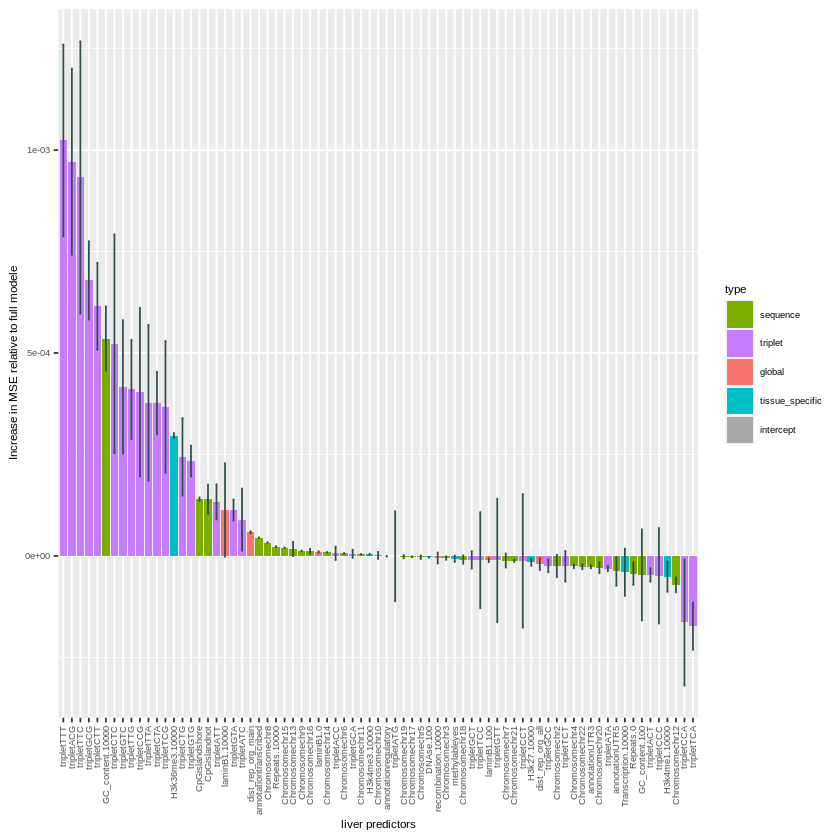

Saving 6.67 x 6.67 in image



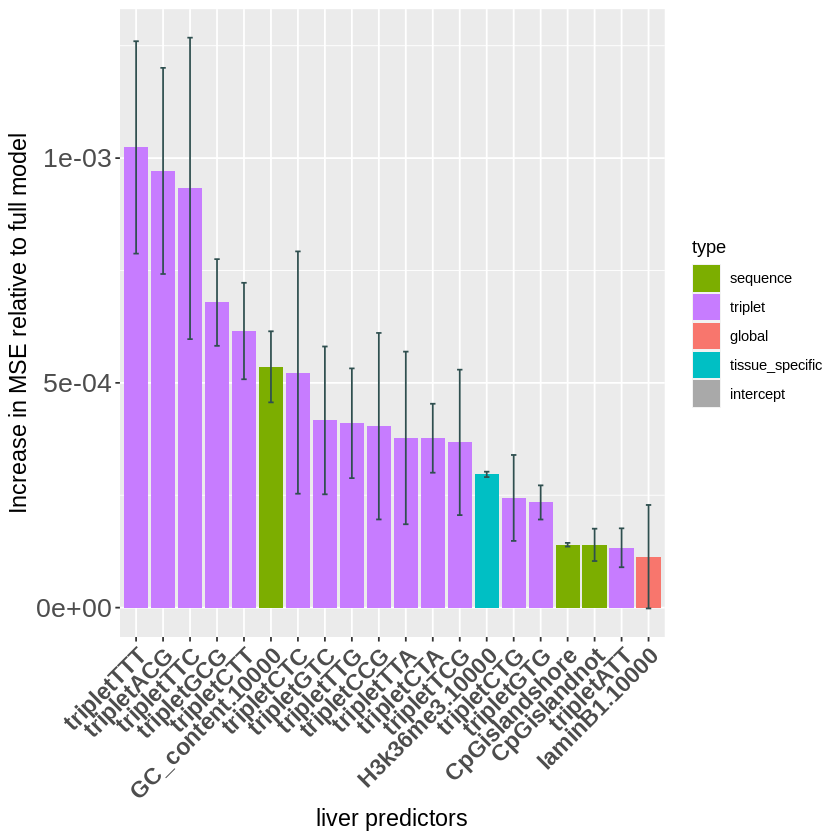

Saving 6.67 x 6.67 in image



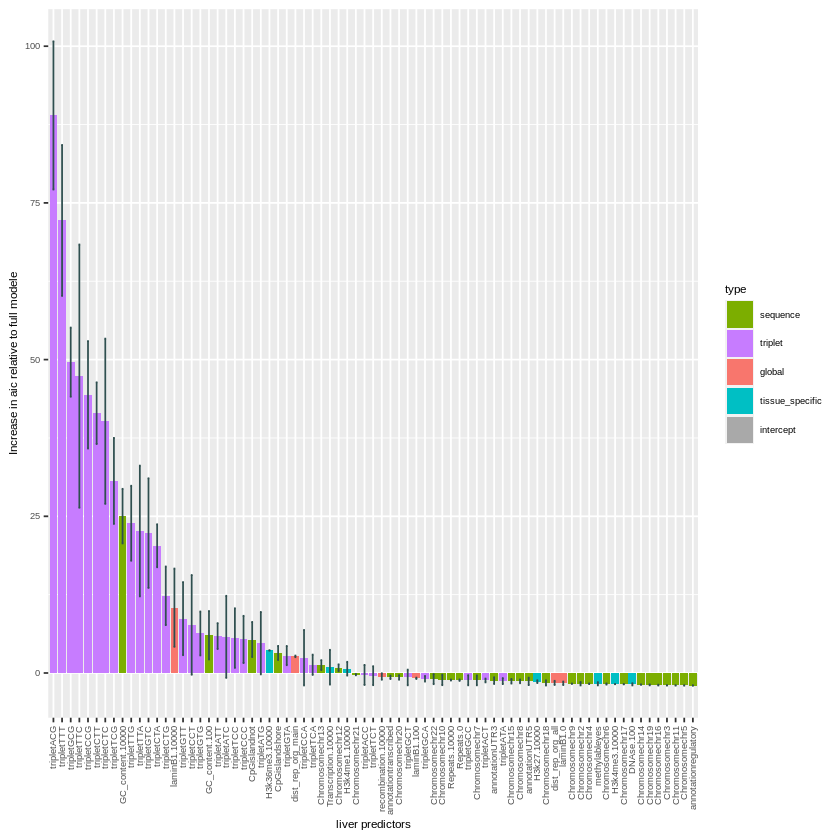

Saving 6.67 x 6.67 in image



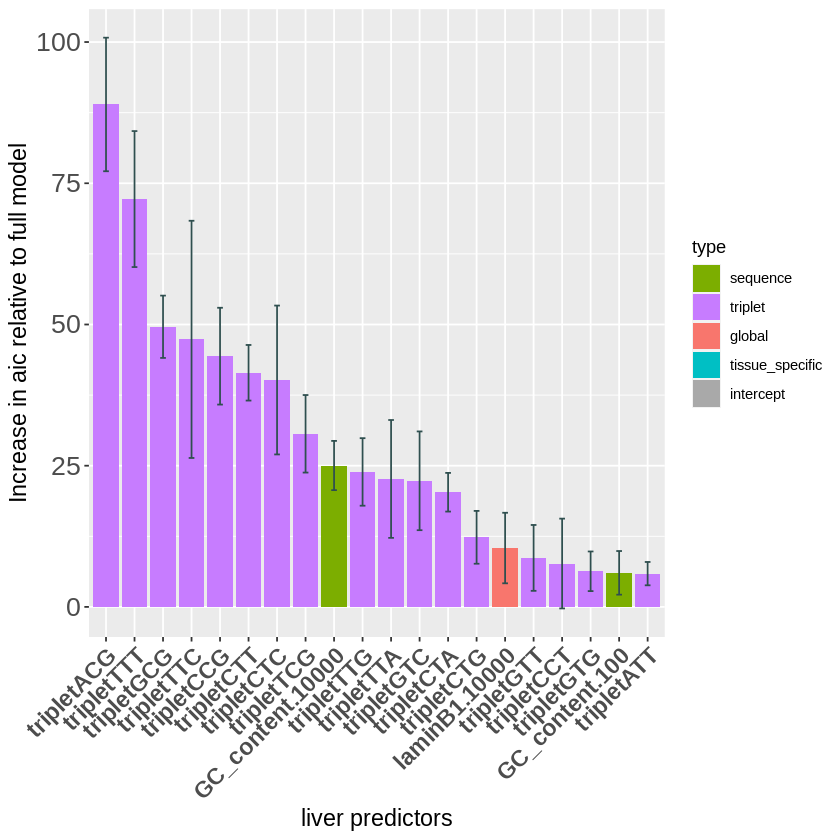

In [1]:
library(stringr)
library(ggplot2)
library(dplyr)

args = commandArgs(trailingOnly=TRUE)
tissue = args[1]
model_name = args[2]
n_samples = as.integer(args[3])

# tissue = "liver"
# model_name = "model7"
# n_samples=2
tmp_file_path = ""


#loading in the data 
all_data <- read.csv(paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_all_data_readyForPrediction.csv",sep=""),header=TRUE)
all_data <- all_data[,!(names(all_data) %in% c("X"))]


#DOING THE LOOP ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#doing the loop for every predictor
preds_to_interRemove <- colnames(all_data)[! colnames(all_data) %in% c('mutation_status',"X")]
mse_df = data.frame(preds_to_interRemove )
colnames(mse_df)<-c("predictor")
aic_df = data.frame(preds_to_interRemove)
colnames(aic_df)<-c("predictor")
for (x in 1:n_samples){#build df in for loop https://stackoverflow.com/questions/13442461/populating-a-data-frame-in-r-in-a-loop
    #setting the training and testing sites (same for all predictor removals)
    sample_sites_train <- sample (1:nrow(all_data), nrow(all_data)/2) 
    sample_sites_test = c(1:nrow(all_data))[-sample_sites_train]
    #calculating the full model and extracting min error 
    model<- glm(mutation_status~., data=all_data[sample_sites_train,],family="binomial")
    max_aic <- AIC(model)#get aic of the model
    probs <- predict.glm(model, all_data[sample_sites_test,], type="response")#get the mse fot he model preidcting on the test sties 
    probs_df <- data.frame(x = probs)
    probs_df <- probs_df %>%#binding the predicted proabilities to the OG data (but the test sites only)
        bind_cols(all_data[sample_sites_test,])
    colnames(probs_df ) <- replace(colnames(probs_df ), 1, "glm_probs")#renaming the glm_probs coloumn
    max_mse<-sum((probs_df$glm_probs - probs_df$mutation_status)**2)/length(probs_df$glm_probs)

    aic_vector <-c()
    mse_vector <-c()
    for (predictor in preds_to_interRemove){
        cur_data <- all_data[,!(names(all_data) %in% c(predictor))] 
        cur_train_data <- cur_data[sample_sites_train,]
        model<- glm(mutation_status~., data=cur_train_data,family="binomial")

        probs <- predict.glm(model, cur_data[sample_sites_test,], type="response")
        probs_df <- data.frame(x = probs)
        probs_df <- probs_df %>%#binding the predicted proabilities to the OG data (but the test sites only)
            bind_cols(cur_data[sample_sites_test,])
        colnames(probs_df ) <- replace(colnames(probs_df ), 1, "glm_probs")#renaming the glm_probs coloumn
        mse<-sum((probs_df$glm_probs - probs_df$mutation_status)**2)/length(probs_df$glm_probs)
        
        aic_vector <- append(aic_vector,AIC(model)-max_aic)
        mse_vector <- append(mse_vector,mse-max_mse)
        }
    mse_df[[paste("trial",x,sep="")]] <- mse_vector
    aic_df[[paste("trial",x,sep="")]] <- aic_vector
}

#SUMMARISING THE LOOP ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
aic_df$mean <- apply(aic_df[,(names(aic_df)!="predictor")],1,mean)
aic_df$sd <- apply(aic_df[,!(names(aic_df)%in%c("predictor","mean"))],1,sd)
aic_df$std_err <- aic_df$sd/sqrt(n_samples)

mse_df$mean <- apply(mse_df[,(names(mse_df)!="predictor")],1,mean)
mse_df$sd <- apply(mse_df[,!(names(mse_df)%in%c("predictor","mean"))],1,sd)
mse_df$std_err <- mse_df$sd/sqrt(n_samples)


#PLOTTING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
colors_ggplot <- c(sequence = "#7CAE00", triplet = "#C77CFF", global ='#F8766D', tissue_specific = '#00BFC4', intercept = "darkgrey")# https://stackoverflow.com/questions/17180115/manually-setting-group-colors-for-ggplot2

#pruning the df and printing to file 
colnames(mse_df)[1] <- "name"
mse_df<-mse_df[order(-mse_df$mean),]
filename = paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_MSEdf.csv",sep="")#this sep is for the filename string
write.csv(mse_df ,filename, row.names = FALSE)
#now for AIC
colnames(aic_df)[1] <- "name"
aic_df<-aic_df[order(-aic_df$mean),]
filename = paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_aicdf.csv",sep="")#this sep is for the filename string
write.csv(aic_df ,filename, row.names = FALSE)

#preparing to plot
mse_df <- mse_df %>%
        mutate(type = case_when(        
            str_detect(name, 'percent') ~ 'sequence',
            str_detect(name, 'Chromosome') ~ 'sequence',
            str_detect(name, 'Repeats') ~ 'sequence',
            str_detect(name, 'site') ~ 'sequence',
            str_detect(name, 'annot') ~ 'sequence',
            str_detect(name, 'content') ~ 'sequence',
            str_detect(name, 'CpG') ~ 'sequence',

            str_detect(name, 'triplet') ~ 'triplet',

            str_detect(name, 'DNAse') ~ 'tissue_specific',
            str_detect(name, 'Transcription') ~ 'tissue_specific',
            str_detect(name, 'H3k') ~ 'tissue_specific',
            str_detect(name, 'methyl') ~ 'tissue_specific',

            str_detect(name, 'recomb') ~ 'global',
            str_detect(name, 'lamin') ~ 'global',
            str_detect(name, 'Replication') ~ 'global',
            str_detect(name, 'dist_rep') ~ 'global',

            str_detect(name, 'Intercept') ~ 'intercept',))
aic_df <- aic_df %>%
        mutate(type = case_when(        
            str_detect(name, 'percent') ~ 'sequence',
            str_detect(name, 'Chromosome') ~ 'sequence',
            str_detect(name, 'Repeats') ~ 'sequence',
            str_detect(name, 'site') ~ 'sequence',
            str_detect(name, 'annot') ~ 'sequence',
            str_detect(name, 'content') ~ 'sequence',
            str_detect(name, 'CpG') ~ 'sequence',

            str_detect(name, 'triplet') ~ 'triplet',

            str_detect(name, 'DNAse') ~ 'tissue_specific',
            str_detect(name, 'Transcription') ~ 'tissue_specific',
            str_detect(name, 'H3k') ~ 'tissue_specific',
            str_detect(name, 'methyl') ~ 'tissue_specific',

            str_detect(name, 'recomb') ~ 'global',
            str_detect(name, 'lamin') ~ 'global',
            str_detect(name, 'Replication') ~ 'global',
            str_detect(name, 'dist_rep') ~ 'global',

            str_detect(name, 'Intercept') ~ 'intercept',
        ))


#global mse plot 
ggplot(mse_df, aes(x = reorder(name, -(mean)), y = mean,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste(tissue,"predictors",sep=" "))+
    ylab("Increase in MSE relative to full modele")+
#     geom_text(aes(y=mean+0.000005*sign(mean),label=name),angle = 90,size=2)+#bars next to bar value 
    theme(text = element_text(size=7),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
    scale_fill_manual(values=colors_ggplot)+
    geom_errorbar(aes(ymin=mean-std_err, ymax=mean+std_err), width=.2,position=position_dodge(.9),color="darkslategrey")
ggsave(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_coef_MSEerror_barplot.pdf",sep=""))
#mse plot top 20 
mse_df_top10 <- head(mse_df[order(-(mse_df$mean)),],n=20)
ggplot(mse_df_top10, aes(x = reorder(name, -(mean)), y = mean,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste(tissue,"predictors",sep=" "))+
    ylab("Increase in MSE relative to full model")+ 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=14),axis.text.y = element_text(size=16))+
    theme(axis.title=element_text(size=14))+
    scale_fill_manual(values=colors_ggplot)+
    geom_errorbar(aes(ymin=mean-std_err, ymax=mean+std_err), width=.2,position=position_dodge(.9),color="darkslategrey")+ #http://www.sthda.com/english/wiki/ggplot2-error-bars-quick-start-guide-r-software-and-data-visualization
    theme(axis.text.x = element_text(face="bold", size=14, angle=45))
ggsave(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_coef_MSEerror_barplot_top10bottom10.pdf",sep=""))
#global aic plot 
ggplot(aic_df, aes(x = reorder(name, -(mean)), y = mean,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste(tissue,"predictors",sep=" "))+
    ylab("Increase in aic relative to full modele")+
#     geom_text(aes(y=mean+0.000005*sign(mean),label=name),angle = 90,size=2)+#bars next to bar value 
    theme(text = element_text(size=7),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
    scale_fill_manual(values=colors_ggplot)+
    geom_errorbar(aes(ymin=mean-std_err, ymax=mean+std_err), width=.2,position=position_dodge(.9),color="darkslategrey")
ggsave(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_coef_aicerror_barplot.pdf",sep=""))
#aic plot top 20 
aic_df_top10 <- head(aic_df[order(-(aic_df$mean)),],n=20)
ggplot(aic_df_top10, aes(x = reorder(name, -(mean)), y = mean,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste(tissue,"predictors",sep=" "))+
    ylab("Increase in aic relative to full model")+ 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=14),axis.text.y = element_text(size=16))+
    theme(axis.title=element_text(size=14))+
    scale_fill_manual(values=colors_ggplot)+
    geom_errorbar(aes(ymin=mean-std_err, ymax=mean+std_err), width=.2,position=position_dodge(.9),color="darkslategrey")+ #http://www.sthda.com/english/wiki/ggplot2-error-bars-quick-start-guide-r-software-and-data-visualization
    theme(axis.text.x = element_text(face="bold", size=14, angle=45))
ggsave(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_coef_aicerror_barplot_top10bottom10.pdf",sep=""))

# scratch 

In [2]:
as.integer("2")

[1] 2

In [ ]:
ggplot(error_df, aes(x = reorder(name, -(increase_in_MSE)), y = increase_in_MSE,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste(tissue,"predictors",sep=" "))+
    ylab("Increase in MSE relative to full modele")+
    geom_text(aes(y=increase_in_MSE+0.2*sign(increase_in_MSE),label=name),angle = 90,size=2)+#bars next to bar value 
    theme(text = element_text(size=7),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
    scale_fill_manual(values=colors_ggplot)

In [70]:
colnames(error_df)

[1] "name"            "increase_in_AIC" "increase_in_MSE" "type"

In [11]:

# #binding the predicted proabilities to the OG data (but the test sites only)
# probs_df <- probs_df %>%
#     bind_cols(all_data[sample_sites_test,])
# #renaming the glm_probs coloumn
# colnames(probs_df ) <- replace(colnames(probs_df ), 1, "glm_probs")
# #writing to file 
# filename = paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_on_",tissue_predOn,"_ProbabilityDf.csv",sep="")#this sep is for the filename string
# write.csv(probs_df ,filename, row.names = FALSE)

In [ ]:


# cur_coef_df <- as.data.frame(coef(model))
# colnames(cur_coef_df) <- c(paste("value_",i,sep=""))
# cur_coef_df<- tibble::rownames_to_column(cur_coef_df, "name") # https://stackoverflow.com/questions/29511215/convert-row-names-into-first-column
# coef_df <- merge(coef_df,cur_coef_df)

# #PREDICTOR ITERATE REMOVE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# preds_to_interRemove <- colnames(all_data)[! colnames(all_data) %in% c('mutation_status',"X")]
# for (predictor in preds_to_interRemove){
#     load(paste(tmp_file_path,"data/",tissue,"/objects/",model_name,"/iterRemove/",tissue,"_model_no_",predictor,".RData",sep=""))
#     load(paste(tmp_file_path,"data/",tissue,"/objects/",model_name,"/",tissue,"_samples_sites_test.RData",sep=""))#sample_sites_test

#     all_data$annotation <- gsub("protein_binding","not_transcribed",all_data$annotation)#there are so few protein binding sites that we may as well omit 
#     #rerplacing with "not_transcribed" is fine as they are the last level before non_transcribed in the annotation module     

#     probs <- predict.glm(cur_model, all_data[sample_sites_test,], type="response")
#     probs_df <- data.frame(x = probs)
#     #binding the predicted proabilities to the OG data (but the test sites only)
#     probs_df <- probs_df %>%
#         bind_cols(all_data[sample_sites_test,])
#     #renaming the glm_probs coloumn
#     colnames(probs_df ) <- replace(colnames(probs_df ), 1, "glm_probs")

#     #writing to file 
#     filename = paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/iterRemove/",tissue,"_no_",predictor,"_ProbabilityDf.csv",sep="")#this sep is for the filename string
#     write.csv(probs_df ,filename, row.names = FALSE)
# }

** copied over the model rdata and relevant into the new model7 directory **

In [3]:
for (x in 1:5){
    print(x)
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


In [1]:
%%bash 
#python chunk 
cd ../../../data
# cp blood/dataframes/model6/predictorDf.txt blood/dataframes/model7/
# cp germline/dataframes/model6/predictorDf.txt germline/dataframes/model7/
# cp liver/dataframes/model6/predictorDf.txt liver/dataframes/model7/
# cp skin/dataframes/model6/predictorDf.txt skin/dataframes/model7/

# cp blood/objects/model6/blood_model.RData blood/objects/model7/
# cp germline/objects/model6/germline_model.RData germline/objects/model7/
# cp liver/objects/model6/liver_model.RData liver/objects/model7/
# cp skin/objects/model6/skin_model.RData skin/objects/model7/

# cp blood/objects/model6/blood_samples_sites_test.RData blood/objects/model7/
# cp germline/objects/model6/germline_samples_sites_test.RData germline/objects/model7/
# cp liver/objects/model6/liver_samples_sites_test.RData liver/objects/model7/
# cp skin/objects/model6/skin_samples_sites_test.RData skin/objects/model7/

cp blood/dataframes/model6/blood_all_data_readyForPrediction.csv blood/dataframes/model7/
cp germline/dataframes/model6/germline_all_data_readyForPrediction.csv germline/dataframes/model7/
cp liver/dataframes/model6/liver_all_data_readyForPrediction.csv liver/dataframes/model7/
cp skin/dataframes/model6/skin_all_data_readyForPrediction.csv skin/dataframes/model7/

# cretaing models where you leave one out to test importance  